In [7]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import seaborn as sns
import matplotlib.pyplot as plt
import quantum_sim as qusi
import pandas as pd

In [2]:
# print the operators
print(qusi.Id(1))
print(qusi.Px(1,0))
print(qusi.Py(1,1))
print(qusi.Pz(1,3))

Id
Px_0
Py_1
Pz_3


In [2]:
# construct a simple product Hamiltonian: H=4(Px_0@2Px_1)
H = qusi.ProductOp([qusi.Pz(1,0),qusi.Pz(1,1)],4)
print(H)

(4) (Pz_0) @ (Pz_1)


In [3]:
# the matrix form of the Hamiltonian:
print(H.as_dense_matrix(2))

[[ 4.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -4.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -4.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  4.+0.j]]


In [2]:
# Hamiltonian for exact dig:
def get_Hamiltonian(N,J,U,h_list):
    assert N==len(h_list)
    H = qusi.SumOp([qusi.ProductOp([qusi.Px(1,i),qusi.Px(1,i+1)],-J) for i in range(N-1)]
                   +[qusi.ProductOp([qusi.Py(1,i),qusi.Py(1,i+1)],-J) for i in range(N-1)]
                  +[qusi.ProductOp([qusi.Pz(1,i),qusi.Pz(1,i+1)],U) for i in range(N-1)]
                  +[qusi.Pz(h_list[i],i) for i in range(N)])
    return H

#Hamiltonian for Trotter:
"""
EvenBond:   ┌────┐      OddBond:               SingleGate:   ┌────┐
    q0   ---│    │------        -------------             ---│    │----
            │    │                                           └────┘
            │    │                 ┌────┐                    ┌────┐
    q1   ---│    │------        ---│    │----             ---│    │----
            └────┘                 │    │                    └────┘
            ┌────┐                 │    │                    ┌────┐
    q2   ---│    │------        ---│    │----             ---│    │----
            │    │                 └────┘                    └────┘
            │    │                                           ┌────┐
    q3   ---│    │------        -------------             ---│    │----
            └────┘                                           └────┘
"""
def get_trotter_Hamiltonian(N,J,U,h_list):
    assert N==len(h_list)
    evens = []
    odds = []
    for i in range(N-1):
        if i%2==0:
            evens.append(i)
        else:
            odds.append(i)
    # The even bond hamiltonian
    H0 = qusi.SumOp([qusi.ProductOp([qusi.Px(1,i),qusi.Px(1,i+1)],-J) for i in evens]
                   +[qusi.ProductOp([qusi.Py(1,i),qusi.Py(1,i+1)],-J) for i in evens]
                  +[qusi.ProductOp([qusi.Pz(1,i),qusi.Pz(1,i+1)],U) for i in evens])
    # The odd bond hamiltonian
    H1 = qusi.SumOp([qusi.ProductOp([qusi.Px(1,i),qusi.Px(1,i+1)],-J) for i in odds]
                   +[qusi.ProductOp([qusi.Py(1,i),qusi.Py(1,i+1)],-J) for i in odds]
                  +[qusi.ProductOp([qusi.Pz(1,i),qusi.Pz(1,i+1)],U) for i in odds])
    # The single gates
    H2 = qusi.SumOp([qusi.Pz(h_list[i],i) for i in range(N)])
    return [H0,H1,H2]

def exact_diag(H,T,t_step):
    return linalg.expm((0-1j)*T/t_step*H)

def basic_trotter(H_list,T,t_step,N):
    eH_list = []
    for H in H_list:
        eH_list.append(exact_diag(H.as_sparse_matrix(N),T,t_step))
    return eH_list[2]@eH_list[1]@eH_list[0]

def symmetric_trotter(H_list,T,t_step,N):
    eH_list = [linalg.expm((0-1j)*T/t_step*H_list[0].as_sparse_matrix(N)),linalg.expm((0-.5j)*T/t_step*H_list[1].as_sparse_matrix(N)),linalg.expm((0-.5j)*T/t_step*H_list[2].as_sparse_matrix(N))]
    return eH_list[2]@eH_list[1]@eH_list[0]@eH_list[1]@eH_list[2]

In [3]:
def get_initial_state(N,s=0):
    if s==0:
        l0 = [1 for i in range(int(N/2))]
        l1 = [0 for i in range(int(N-N/2))]
        return qusi.qstate(l0+l1)
    else:
        return qusi.qstate([i%2 for i in range(N)])

In [4]:
def get_hlist(N,h):
    return np.random.uniform(-h,h,N)

In [5]:
# test the Hamiltonian:
N = 6
J = 1
U = 0
h = 0
#h = 1.5
h_list = [i*h for i in range(N)]

T = 2.5
t_step = 250
s = 0
#s = 1

D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
C:\Users\God_Zao\AppData\Local\Temp\ipykernel_15144\3503799215.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  local_mag[i][j+1] = q.local_magnetism(i)


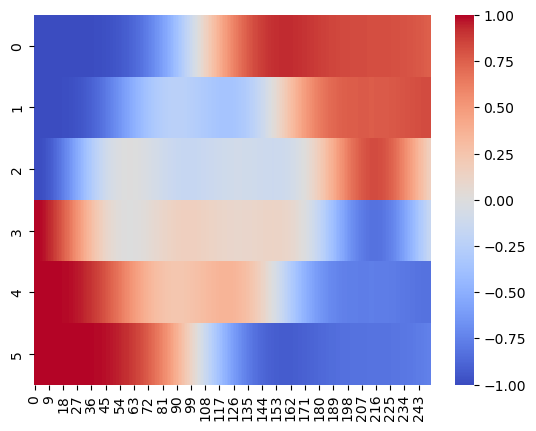

In [8]:
# exact diagonalization:
H = get_Hamiltonian(N,J,U,h_list)
eH = exact_diag(H.as_sparse_matrix(N),T,t_step)
q = get_initial_state(N,s)
local_mag = np.zeros([N,t_step+1])
ref_state = []

for i in range(N):
    local_mag[i][0] = q.local_magnetism(i)
for j in range(t_step):
    ref_state.append(q.time_evolution(eH))
    for i in range(N):
        local_mag[i][j+1] = q.local_magnetism(i)
ax = sns.heatmap(local_mag,annot = False,cmap='coolwarm')
#ax.set_yticks([i*T/t_step for i in range(t_step+1)])
plt.show()
ed_df = pd.DataFrame({
    'Z4':local_mag[3],
    'Z6':local_mag[5]
})
ed_df.to_csv('data\ed_local_mag.csv', index=False)

D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
C:\Users\God_Zao\AppData\Local\Temp\ipykernel_4456\3608486987.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  local_mag[i][j+1] = q.local_magnetism(i)


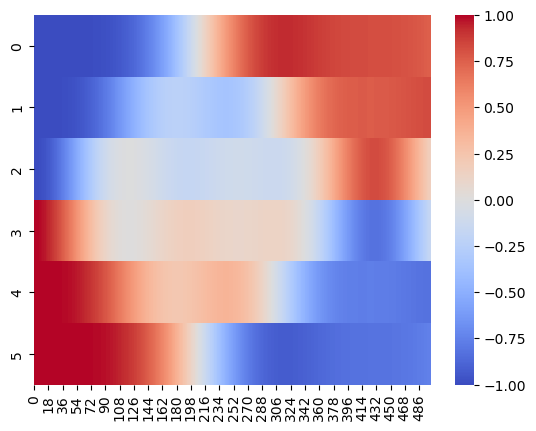

In [16]:
# basic trotter
H_list = get_trotter_Hamiltonian(N,J,U,h_list)
eH = basic_trotter(H_list,T,t_step,N)
q = get_initial_state(N,s)
local_mag = np.zeros([N,t_step+1])
basic_state = []

for i in range(N):
    local_mag[i][0] = q.local_magnetism(i)
for j in range(t_step):
    basic_state.append(q.time_evolution(eH))
    for i in range(N):
        local_mag[i][j+1] = q.local_magnetism(i)
ax = sns.heatmap(local_mag,annot = False,cmap='coolwarm')
#ax.set_yticks([i*T/t_step for i in range(t_step+1)])
plt.show()

D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
C:\Users\God_Zao\AppData\Local\Temp\ipykernel_11820\3218339482.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  local_mag[i][j+1] = q.local_magnetism(i)


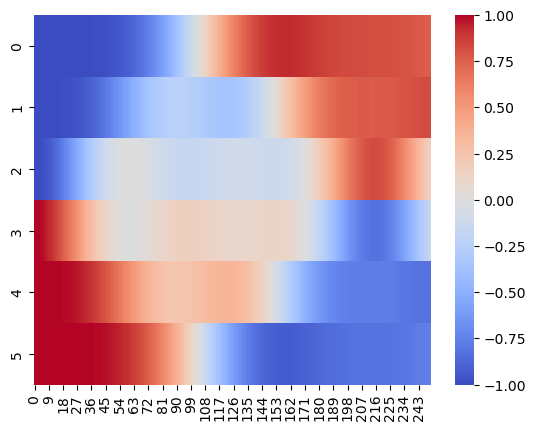

In [6]:
# symetric trotter
H_list = get_trotter_Hamiltonian(N,J,U,h_list)
eH = symmetric_trotter(H_list,T,t_step,N)
q = get_initial_state(N,s)
local_mag = np.zeros([N,t_step+1])
symmetric_state = []

for i in range(N):
    local_mag[i][0] = q.local_magnetism(i)
for j in range(t_step):
    symmetric_state.append(q.time_evolution(eH))
    for i in range(N):
        local_mag[i][j+1] = q.local_magnetism(i)
ax = sns.heatmap(local_mag,annot = False,cmap='coolwarm')
#ax.set_yticks([i*T/t_step for i in range(t_step+1)])
plt.show()
tro_df = pd.DataFrame({
    'Z4':local_mag[3],
    'Z6':local_mag[5]
})
#tro_df.to_csv('data/tro_local_mag.csv', index=False)

In [16]:
tro_df.to_csv('data/tro_local_mag.csv',index=False)

D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
C:\Users\God_Zao\AppData\Local\Temp\ipykernel_15144\3741536910.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  local_mag[i][j+1] = q.local_magnetism(i)


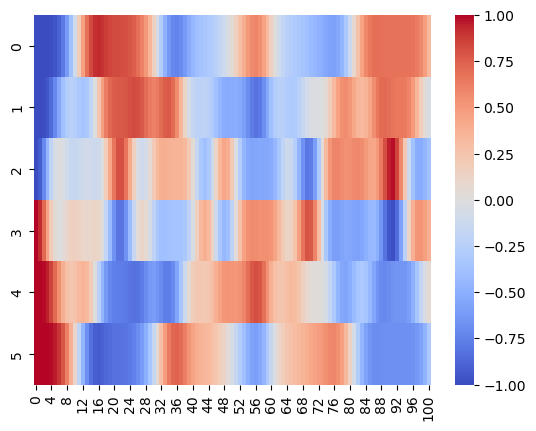

D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
C:\Users\God_Zao\AppData\Local\Temp\ipykernel_15144\3741536910.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  local_mag[i][j+1] = q.local_magnetism(i)


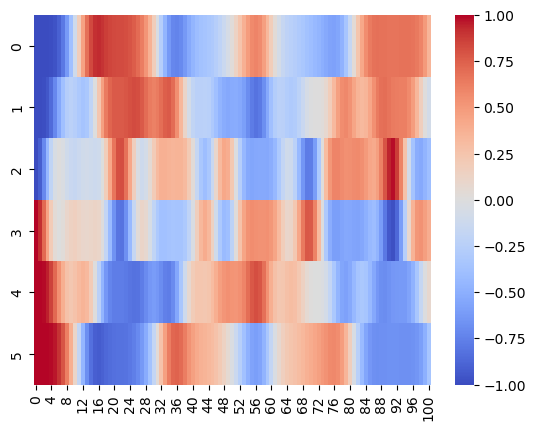

In [17]:
# Provide data, do not run
T=10
t_step=100
H = get_Hamiltonian(N,J,U,h_list)
eH = exact_diag(H.as_sparse_matrix(N),T,t_step)
q = get_initial_state(N,s)
local_mag = np.zeros([N,t_step+1])
ref_state = []
for i in range(N):
    local_mag[i][0] = q.local_magnetism(i)
for j in range(t_step):
    ref_state.append(q.time_evolution(eH))
    for i in range(N):
        local_mag[i][j+1] = q.local_magnetism(i)
ax = sns.heatmap(local_mag,annot = False,cmap='coolwarm')
#ax.set_yticks([i*T/t_step for i in range(t_step+1)])
plt.show()
ed_df = pd.DataFrame({
    'Z6':local_mag[5]
})
ed_df.to_csv('data/ed_local_mag_long.csv', index=False)

H_list = get_trotter_Hamiltonian(N,J,U,h_list)
eH = symmetric_trotter(H_list,T,t_step,N)
q = get_initial_state(N,s)
local_mag = np.zeros([N,t_step+1])
symmetric_state = []

for i in range(N):
    local_mag[i][0] = q.local_magnetism(i)
for j in range(t_step):
    symmetric_state.append(q.time_evolution(eH))
    for i in range(N):
        local_mag[i][j+1] = q.local_magnetism(i)
ax = sns.heatmap(local_mag,annot = False,cmap='coolwarm')
#ax.set_yticks([i*T/t_step for i in range(t_step+1)])
plt.show()
tro_df = pd.DataFrame({
    'Z6':local_mag[5]
})
tro_df.to_csv('data/tro_local_mag_long.csv', index=False)

D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
C:\Users\God_Zao\AppData\Local\Temp\ipykernel_11820\3991255830.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  XX_disorder_result[h][t] = q.N_half()


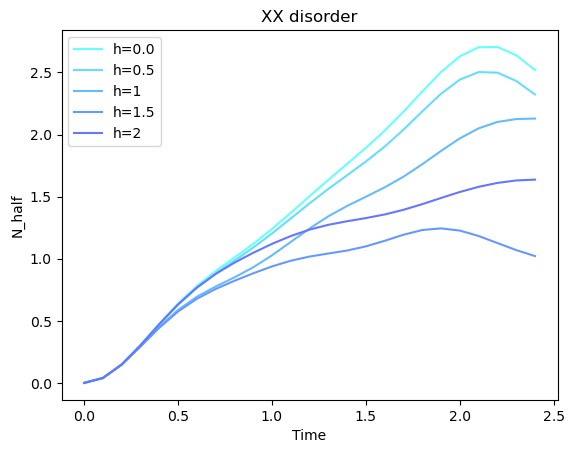

In [8]:
T = 2.5
t_step = 25
h_list = [0.,0.5,1,1.5,2]
#U_list = [0.,0.5,1,1.5,2]
XX_disorder_result = {h:np.zeros(t_step, dtype=float) for h in h_list}
color_list = ['#66ffff','#66ddff','#66bbff','#6699ff','#6677ff']
dt = T/t_step
t_tick = [i*dt for i in range(t_step)]
i=0
eH_list = []
for h in h_list:
    hj_list = get_hlist(N,h)
    H_list = get_trotter_Hamiltonian(N,J,U,hj_list)
    eH = symmetric_trotter(H_list,T,t_step,N)
    eH_list.append(eH)
    #H = get_Hamiltonian(N,J,U,hj_list)
    #eH = exact_diag(H.as_sparse_matrix(N),T,t_step)
    q = get_initial_state(N,s)
    XX_disorder_result[h][0] = q.N_half()
    for t in range(1,t_step):
        q.time_evolution(eH)
        XX_disorder_result[h][t] = q.N_half()
    plt.plot(t_tick, XX_disorder_result[h], color = color_list[i],label = f"h={h}")
    i+=1
plt.xlabel('Time')
plt.ylabel('N_half')
plt.title('XX disorder')
plt.legend()
plt.show()

C:\Users\God_Zao\AppData\Local\Temp\ipykernel_11820\3446420524.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  XXZ_disorder_result[U][t] = q.N_half()


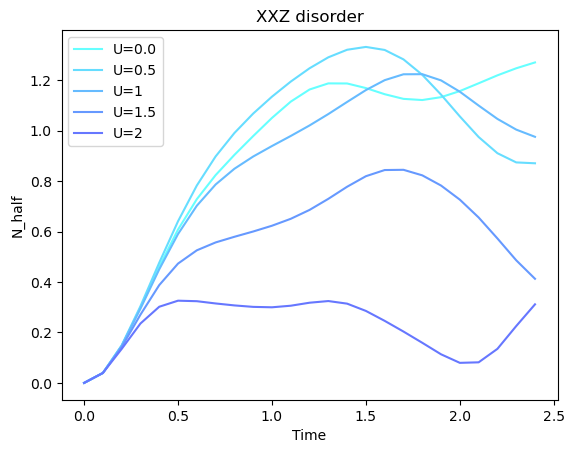

In [9]:
T = 2.5
t_step = 25
U_list = [0.,0.5,1,1.5,2]
h=1.5
color_list = ['#66ffff','#66ddff','#66bbff','#6699ff','#6677ff']
dt = T/t_step
XXZ_disorder_result = {U:np.zeros(t_step, dtype=float) for U in U_list}
h_list = get_hlist(N,h)
t_tick = [i*dt for i in range(t_step)]
i=0
for U in U_list:
    H_list = get_trotter_Hamiltonian(N,J,U,h_list)
    eH = symmetric_trotter(H_list,T,t_step,N)
    q = get_initial_state(N,s)
    XXZ_disorder_result[U][0] = q.N_half()
    for t in range(1,t_step):
        q.time_evolution(eH)
        XXZ_disorder_result[U][t] = q.N_half()
    plt.plot(t_tick, XXZ_disorder_result[U], color = color_list[i],label = f"U={U}")
    i+=1
plt.title('XXZ disorder')
plt.xlabel('Time')
plt.ylabel('N_half')
plt.legend()
plt.show()

C:\Users\God_Zao\AppData\Local\Temp\ipykernel_11820\1322153020.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  XXZ_disorder_result[U][t] = q.N_half()


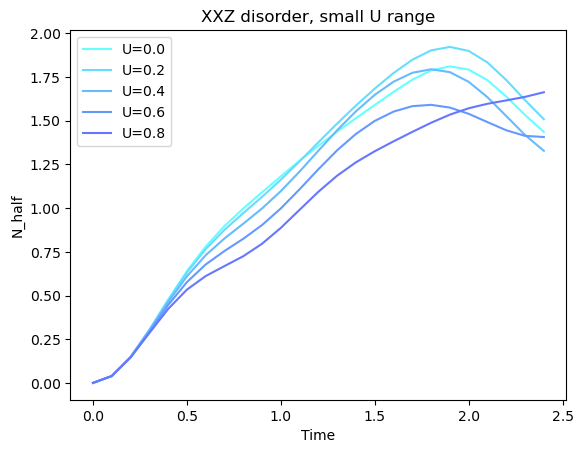

In [10]:
T = 2.5
t_step = 25
U_list = [0.,0.2,0.4,0.6,0.8]
h=1.5
color_list = ['#66ffff','#66ddff','#66bbff','#6699ff','#6677ff']
dt = T/t_step
XXZ_disorder_result = {U:np.zeros(t_step, dtype=float) for U in U_list}
h_list = get_hlist(N,h)
t_tick = [i*dt for i in range(t_step)]
i=0
for U in U_list:
    H_list = get_trotter_Hamiltonian(N,J,U,h_list)
    eH = symmetric_trotter(H_list,T,t_step,N)
    q = get_initial_state(N,s)
    XXZ_disorder_result[U][0] = q.N_half()
    for t in range(1,t_step):
        q.time_evolution(eH)
        XXZ_disorder_result[U][t] = q.N_half()
    plt.plot(t_tick, XXZ_disorder_result[U], color = color_list[i],label = f"U={U}")
    i+=1
plt.title('XXZ disorder, small U range')
plt.xlabel('Time')
plt.ylabel('N_half')
plt.legend()
plt.show()

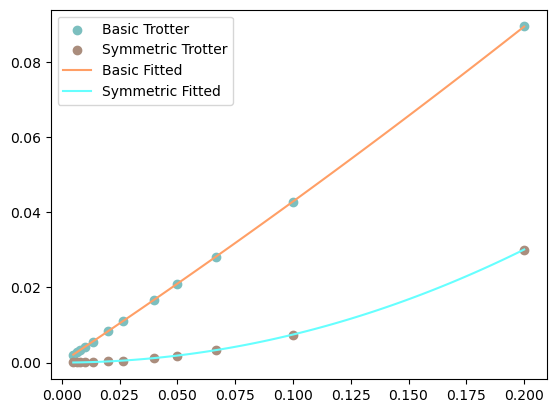

In [11]:
T = 2
t_step = [10,20,30,40,50,75,100,150,200,250,300,400]
dt_list = [T/t for t in t_step]
color_list = ['#66ffff','#FF9F66','#7CBFBF','#AA8D7D']
basic_dif = []
symm_dif = []
H_ref = get_Hamiltonian(N,J,U,h_list)
H_list = get_trotter_Hamiltonian(N,J,U,h_list)
for i in range(len(t_step)):
    dt = dt_list[i]
    eH_ref = exact_diag(H_ref.as_sparse_matrix(N),T,t_step[i])
    eH_basic = basic_trotter(H_list,T,t_step[i],N)
    eH_symm = symmetric_trotter(H_list,T,t_step[i],N)
    q_ref = get_initial_state(N,s)
    q_basic = get_initial_state(N,s)
    q_symm = get_initial_state(N,s)
    for t in range(t_step[i]):
        q_ref.time_evolution(eH_ref)
        q_basic.time_evolution(eH_basic)
        q_symm.time_evolution(eH_symm)
    basic_dif.append(q_basic.state_distance(q_ref))
    symm_dif.append(q_symm.state_distance(q_ref))
plt.scatter(dt_list,basic_dif,color = color_list[2],label = 'Basic Trotter')
plt.scatter(dt_list,symm_dif,color = color_list[3],label = 'Symmetric Trotter')

coeff_basic_fit = np.polyfit(dt_list,basic_dif,2)
poly_basic_order = np.poly1d(coeff_basic_fit)
coeff_symm_fit = np.polyfit(dt_list,symm_dif,3)
poly_symm_order = np.poly1d(coeff_symm_fit)

x_fit = np.linspace(min(dt_list), max(dt_list), 100)

basic_fit = poly_basic_order(x_fit)
symm_fit = poly_symm_order(x_fit)
plt.plot(x_fit,basic_fit,color = color_list[1],label='Basic Fitted')
plt.plot(x_fit,symm_fit,color = color_list[0],label='Symmetric Fitted')
plt.title('Err of 1st and 2nd order Suzuki')
plt.xlabel('dt=T/N')
plt.ylabel('Err related to Reference state')
plt.legend()
plt.show()

In [5]:
H_list = get_trotter_Hamiltonian(2,-1,0,[0.6,0.6])

In [6]:
for i in range(3):
    print(H_list[i])
    print(H_list[i].as_dense_matrix(2))

(Px_0) @ (Px_1) + (Py_0) @ (Py_1)
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 2.+0.j 0.+0.j]
 [0.+0.j 2.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
<empty sum>
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
(0.6)Pz_0 + (0.6)Pz_1
[[ 1.2+0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -1.2+0.j]]
